In [68]:
!pip install pyarrow==0.15

In [69]:
import pandas as pd
import pyarrow
from matplotlib import pyplot as plt

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading datasets

In [71]:
clients = pd.read_csv("/content/drive/My Drive/hack_data/clients.csv")
clients.head(5)

,client_id,gender,city,birthyear
0,1a47d62dddacc03fe90c15652f7ae1a4,M,Other,1990.0
1,9cb909f701d25d548e953bff81192b56,F,Other,1969.0
2,d5da0f5b841b4f83383202807995027a,M,Other,1976.0
3,13ed7f16810b17b8cee6de834ac79a48,F,Moscow,1966.0
4,215fe3ea7d5bf0415e5504e2a7f33551,F,Other,1988.0


In [72]:
materials = pd.read_csv("/content/drive/My Drive/hack_data/materials.csv")
materials.tail(5)

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco
105604,feeddbacd9eed3bac85b1571ac79e40e,NONFOOD,3295c76acbf4caaed33c36b1b5fc2cb1,11704817e347269b7254e744b5e22dac,e47e165040e2914783a451509bbc8180,8ca0d8745f91fb71551be26b1ca854f4,0,0
105605,e218c4c3676927e53b95a12ffe9e721a,FOOD,02e74f10e0327ad868d138f2b4fdd6f0,df0e09d6f25a15a815563df9827f48fa,a03ddfb4b641e98de3223765162217c3,e3319f2f4767af113d82174f662f2d4e,1,1
105606,9a5e2e34d8406616f5981868b4576444,NONFOOD,fc490ca45c00b1249bbe3554a4fdf6fb,865bf46435bd84fa5d89f64cf3ba7347,e2a75db437bee7d34615fccf32d7a464,546614030cdbddcae3de351852962759,0,0
105607,d208910eb82fa1f57684f793f93521a4,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,90365351ccc7437a1309dc64e4db32a3,ea9cffc9bd2bf8a0fb128d223f6a4282,7f1dbcf6ab15c23093508627ca12b8b1,0,0
105608,ac6bf06bbda21e48809e734c1f6fa010,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,90365351ccc7437a1309dc64e4db32a3,65415da77b0f2c4d59897a3c1d7130f5,7f1dbcf6ab15c23093508627ca12b8b1,0,0


In [73]:
plants = pd.read_csv("/content/drive/My Drive/hack_data/plants.csv")
plants.tail(4)

,plant,plant_type,city
384,238d77348d954fdd455aabb09575f2d0,SM,Other
385,6e1acaeb838a890e6570284f73e1d00f,SM,Other
386,7fc3ee9aad33036cc501b2ca7c163fc1,SM,Other
387,8a5dd78aadea6ffc984bda22064adb92,SM,Other


In [74]:
transactions = pd.read_parquet("/content/drive/My Drive/hack_data/transactions.parquet", engine='pyarrow')#, columns=['chq_date', 'material'])

In [ ]:
#Extract data about promo
ispromo = transactions[['chq_id', 'material', 'is_promo']]
transactions.drop(columns = 'is_promo', inplace=True)

In [77]:
transactions.head()

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.0,249.99
2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,012,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99
3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,013,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99
4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,011,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.0,53.98


In [78]:
# List to group data
col_set = []
for i in transactions.columns:
  if i!= 'sales_count' and 	i!= 'sales_sum' and i !='material' and i!='chq_position':
    col_set.append(i)


In [79]:
#Group data to compute sales
grouped_for_sums = transactions[col_set+['sales_sum']].groupby(by=col_set, as_index=False).sum()
grouped_for_count = transactions[col_set+['material']].groupby(by=col_set, as_index=False).count()
grouped_for_sums = grouped_for_sums.merge(grouped_for_count, how = 'left', left_on = col_set, right_on = col_set)

In [89]:
grouped_for_sums.head()

,chq_id,plant,chq_date,client_id,sales_sum,material,gender,city_x,birthyear,plant_type,city_y,diff,sec
0,00000391443926003b45cebac9a4c0b2,6e1acaeb838a890e6570284f73e1d00f,2017-01-14,8a5c839e26cb4a6eedadce113cceb253,164.0,2,M,Other,28.0,SM,Other,379 days,32745600.0
1,0000086694a97b18d2b5e5cfc309ab76,a0b202073aa35e456aeada81d3a98c67,2017-07-22,191412d730a981ce6ae809b8ef8a1070,821.0,8,F,Moscow,30.0,SM,Moscow,568 days,49075200.0
2,00000b7bb8fd947f62aeed1bba4b6fbb,2d0974b2436345d99f7152c3fc44a609,2016-11-13,19c47bc27fdb0c828ef60074a67b8733,326.0,6,F,Other,47.0,HM,Other,317 days,27388800.0
3,00000d5d627d67cacb2ba17705635ca7,3c0d8d9b8a1bdd4eca72ef03f6151254,2017-05-28,c045e1f39fd88c7c8b3afac0b3cd1778,1713.0,7,M,Other,54.0,HM,Other,513 days,44323200.0
4,000010ba9e98d7316de3a8a862fc2d49,8c5781246fcb0296e1f11cd4e2eee68d,2017-02-21,f277f6302e334cb8d9324fd386e7ba5b,2032.0,19,M,Other,25.0,HM,Other,417 days,36028800.0


In [ ]:
Merging datasets

In [90]:
grouped_for_sums = grouped_for_sums.merge(clients, how='left', left_on='client_id', right_on='client_id')

In [91]:
grouped_for_sums = grouped_for_sums.merge(plants, how='left', left_on='plant', right_on='plant')

In [92]:
grouped_for_sums = grouped_for_sums.dropna() 



In [83]:
for i in grouped_for_sums.index:
  grouped_for_sums['birthyear'][i] = grouped_for_sums['chq_date'][i].year.real-grouped_for_sums['birthyear'][i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Transforming datetime to absolute values

In [84]:
grouped_for_sums['diff'] = grouped_for_sums['chq_date'] -   pd.to_datetime('2016-01-01')
grouped_for_sums['sec'] = grouped_for_sums['diff'].dt.total_seconds()



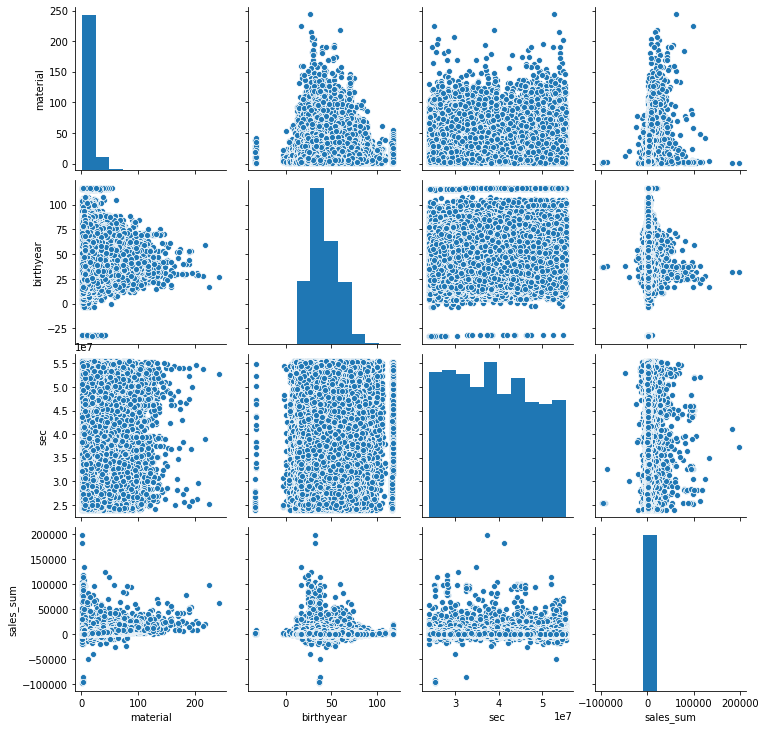

In [85]:
#Vizualization of features
import seaborn as sns
sns.pairplot(grouped_for_sums[['material','birthyear','sec','sales_sum']])

Start of time series of sales

In [86]:
materials_two_columns = materials[['material', 'hier_level_4']]
materials_two_columns.head()

,material,hier_level_4
0,35cbdf61de9e19c8b417327aaef14c88,9eed45f71360b4b1e2590637467220e5
1,c0b0bf24d4ec71da3d304f761ec555d8,de2eb747e0896c050905a6b635ab800a
2,f0fc5e654a81a7c4b8ba8d7c26546e14,8a969031832c535daf96e0c2aed8e814
3,353693e64fb5f9e2d29746d7fe6edf1e,4c0dc012ebb679a18b244c53c6f59b5a
4,5d9e0b4302ce95448cae72165ff4cf5b,4c0dc012ebb679a18b244c53c6f59b5a


In [9]:
df_categ_date = transactions.merge(materials_two_columns, how='left', left_on='material', right_on='material').groupby(['chq_date', 'hier_level_4'], as_index=False).count()

In [10]:
df_categ_date['diff'] = df_categ_date['chq_date'] -   df_categ_date['chq_date'][0]
df_categ_date['sec'] = df_categ_date['diff'].dt.total_seconds()
df_categ_date.head()

,chq_date,hier_level_4,chq_id,plant,chq_position,client_id,material,sales_count,sales_sum,diff,sec
0,2016-10-04,001d2d283b7f3c7378e363313b483e51,566,566,566,566,566,566,566,0 days,0.0
1,2016-10-04,002fc5b5b4131c6ea6412ec21999589e,141,141,141,141,141,141,141,0 days,0.0
2,2016-10-04,007496ff404d0a1d4e5c993492d4b99a,497,497,497,497,497,497,497,0 days,0.0
3,2016-10-04,0079c916e4207b3b87ba54cd0565ecc0,40,40,40,40,40,40,40,0 days,0.0
4,2016-10-04,00b5b66f70a7b486195837da0e75aef6,3,3,3,3,3,3,3,0 days,0.0


In [14]:
# Fitting data with ARMA starts here
# The main idea is to show, that data about sales of categories of products could be predicted and decisions about logistics 
# could be done based on this predictions - if we expect growth of sales at one day, it is crutial to have this goods in shop 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0, 0.5, 'Normalized Sales')

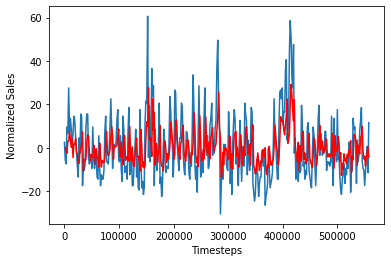

In [88]:
model = ARIMA(endog = df_categ_date_elem['material'] -df_categ_date_elem['material'].mean(),  order=(2,1,2))
results = model.fit( disp=-1)
plt.plot(df_categ_date_elem['material'] - df_categ_date_elem['material'].mean())
plt.plot(-results.fittedvalues, color='red')
plt.xlabel("Timesteps")
plt.ylabel("Normalized Sales")
#Import, fit and plot ARIMA model